In [15]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

In [3]:
path = '/glade/campaign/collections/rda/data/d083003/2024/202411/'

In [6]:
!rm /glade/u/home/jhenao/temp.idx
ds_1 = xr.open_dataset(
    path + "gdas1.fnl0p25.2024112118.f00.grib2", 
    engine="cfgrib",
    backend_kwargs={"indexpath": "/glade/u/home/jhenao/temp.idx",
                    "filter_by_keys": {"typeOfLevel": "atmosphereSingleLayer"}}
)

ds_2 = xr.open_dataset(
    path + "gdas1.fnl0p25.2024112118.f00.grib2", 
    engine="cfgrib",
    backend_kwargs={"indexpath": "/glade/u/home/jhenao/temp.idx",
                    "filter_by_keys": {"typeOfLevel": "surface"}}
)

#!rm /glade/u/home/jhenao/temp.idx


In [7]:
# check the dataset info
#ds_2 or ds_1
ds_1

<xarray.Dataset> Size: 17MB
Dimensions:                (latitude: 721, longitude: 1440)
Coordinates:
    time                   datetime64[ns] 8B ...
    step                   timedelta64[ns] 8B ...
    atmosphereSingleLayer  float64 8B ...
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    valid_time             datetime64[ns] 8B ...
Data variables:
    pwat                   (latitude, longitude) float32 4MB ...
    cwat                   (latitude, longitude) float32 4MB ...
    r                      (latitude, longitude) float32 4MB ...
    tozne                  (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-10-02T10:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [23]:
# cut the dataset for the Western US only - it 

lat_min, lat_max = 10, 60
lon_min, lon_max = -180, -90

subset_1 = ds_1.sel(
    latitude=slice(lat_max, lat_min),   # latitude is usually decreasing
    longitude=slice(lon_min % 360, lon_max % 360)  # convert to 0–360 if needed
)

subset_2 = ds_2.sel(
    latitude=slice(lat_max, lat_min),   # latitude is usually decreasing
    longitude=slice(lon_min % 360, lon_max % 360)  # convert to 0–360 if needed
)

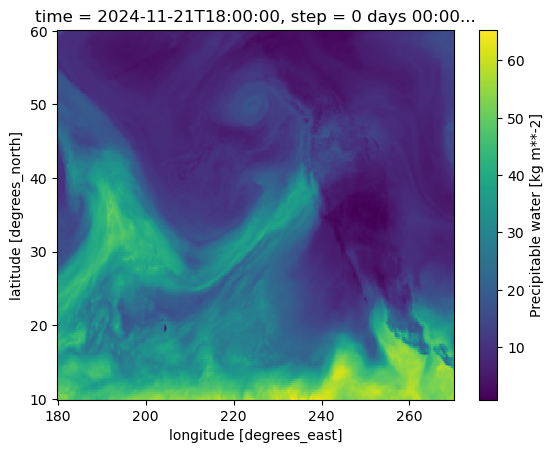

In [24]:
# plot the subset using xarray

subset_1.pwat.plot()

In [25]:
lon = ds_1.longitude
lat = ds_1.latitude
pwat = ds_1.pwat

In [26]:
# get time as character
valid = ds_1.valid_time.dt.strftime("%Y-%m-%d %H:%M:%S").values

In [27]:
# get variable name and units

var = ds_1['pwat'].attrs['long_name']
unit = ds_1['pwat'].attrs['units']

In [28]:
# get wrf domain limits
path_wrf = '/glade/work/jhenao/atm746/WPS/'
ds_geo1 = xr.open_dataset(path_wrf + "geo_em.d01.nc")
ds_geo2 = xr.open_dataset(path_wrf + "geo_em.d02.nc")

def getborders(lattemp,lontemp):
    blats = np.concatenate([lattemp[0,:],lattemp[:,-1],lattemp[-1,::-1],lattemp[::-1,0]])
    blons = np.concatenate([lontemp[0,:],lontemp[:,-1],lontemp[-1,::-1],lontemp[::-1,0]])
    return blats,blons

lats1,lons1 = getborders(ds_geo1.XLAT_C[0,:],ds_geo1.XLONG_C[0,:])
lats2,lons2 = getborders(ds_geo2.XLAT_C[0,:],ds_geo2.XLONG_C[0,:])



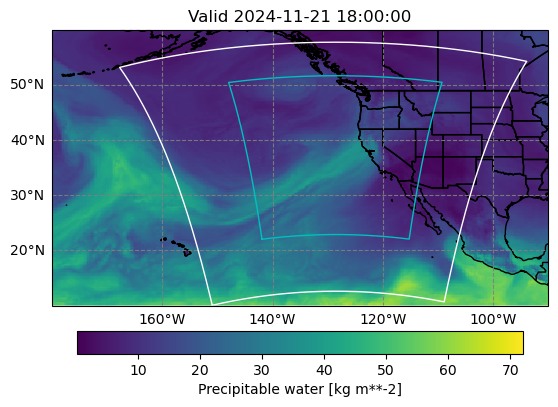

In [30]:
# make a costume plot using Cartopy


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# the file is global, so cut the part we are interested in
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# plot pwat variabile in space
cf = ax.pcolormesh(lon, lat, pwat, cmap='viridis', transform=ccrs.PlateCarree())

ax.plot(lons1,lats1, 'w-', lw=1,transform=ccrs.PlateCarree(),zorder=500)
ax.plot(lons2,lats2, 'c-', lw=1,transform=ccrs.PlateCarree(),zorder=500)

# add map features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)

grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    color='gray', alpha=0.9, linestyle='--')
grid.top_labels = False
grid.right_labels = False

cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.07, shrink=0.9)
cbar.set_label(var + ' [' + unit + ']')  # Customize label as needed

ax.set_title('Valid ' + valid)

plt.show()

In [128]:
lon = ds_2.longitude
lat = ds_2.latitude
gust = ds_2.gust


var = ds_2['gust'].attrs['long_name']
unit = ds_2['gust'].attrs['units']

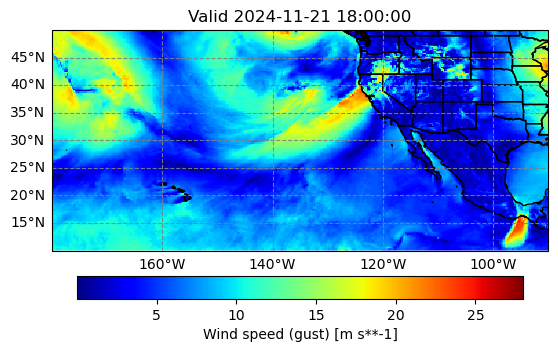

In [129]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# the file is global, so cut the part we are interested in
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# plot pwat variabile in space
cf = ax.pcolormesh(lon, lat, gust, cmap='jet', vmax=28, transform=ccrs.PlateCarree())

# add map features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)

grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    color='gray', alpha=0.9, linestyle='--')
grid.top_labels = False
grid.right_labels = False

cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.07, shrink=0.9)
cbar.set_label(var + ' [' + unit + ']')  # Customize label as needed

ax.set_title('Valid ' + valid)

plt.show()

## we see the AR in the input data !

### lets see the difference in the forecasts and analysis files of FNL


the name of the files contains the date of the start of simulation and the "step"

`gdas1.fnl0p25.2024111900.f06.grib2`

the start of simulation is `2024111900` and `f06` indicates that it is a forecast of 6h out

so the valid date is `2024-11-19 06Z`

it is a forecast. For a valid date of `2024-11-19 06Z` we can use the analysis

`gdas1.fnl0p25.2024111906.f00.grib2`



In [155]:
!rm /glade/u/home/jhenao/temp.idx
ds_00 = xr.open_dataset(
    path + "gdas1.fnl0p25.2024111900.f00.grib2",
    engine="cfgrib",
    backend_kwargs={"indexpath": "/glade/u/home/jhenao/temp.idx",
                    "filter_by_keys": {'stepType': 'instant', 'typeOfLevel': 'surface'}}
)

!rm /glade/u/home/jhenao/temp.idx
ds_06 = xr.open_dataset(
    path + "gdas1.fnl0p25.2024111900.f06.grib2",
    engine="cfgrib",
    backend_kwargs={"indexpath": "/glade/u/home/jhenao/temp.idx",
                    "filter_by_keys": {'stepType': 'instant', 'typeOfLevel': 'surface'}}
)


In [156]:
ds_00.valid_time.dt.strftime("%Y-%m-%d %H:%M:%S").values

array('2024-11-19 00:00:00', dtype=object)

In [157]:
ds_06.valid_time.dt.strftime("%Y-%m-%d %H:%M:%S").values

array('2024-11-19 06:00:00', dtype=object)